# ADAroundTheWorld2023 - Milestone 3

## Abstract <a class="anchor" id="abstract"></a>

In 2004, American entrepreneur Frans Johansson published the book “The Medici Effect: Breakthrough Insights at the Intersection of Ideas, Concepts, and Cultures”. In other words, by merging ideas from a range of diverse backgrounds, one can increase the likelihood of intellectual cross-pollination, which might lead to innovation and success. Our goal is to see if this holds true in the movie industry.

We use the genre, plot and rating information about the movies to generate graphs, which enables us to measure different centrality metrics. These will be used in the correlation analysis, where we measure the linear dependency between metrics and the IMDB rating, which is used as a proxy of success. Additionally, partial correlation will be performed by controlling possible confounders. 

The results indicate no association between "being at the intersection" and the success of a movie. Thus, based on the applied approach, we can say that the **Medici effect does not hold in the movie industry**.

## Table of Contents

Please do not try to click on them in GitHub as GitHub renders it differently and the links only work locally.

&emsp;&ensp;&ensp;[Abstract](#abstract)<br style="margin-bottom:0.5em;">
&emsp;&emsp;[1 - Preprocessing & Initial Analysis](#preprocess)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[1.1 - Preprocessing](#preprocessing-child)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[1.2 - Merging](#merging)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[1.3 - First Glance](#first-glance)<br style="margin-bottom:0.5em;">
&emsp;&emsp;[2 - Theory of Centrality Metrics](#theory)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[2.1 - Betweenness](#betweenness)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[2.2 - Degree](#degree)<br style="margin-bottom:0.5em;">
&emsp;&emsp;[3 - Creating Network Graphs](#creating-network)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[3.1 - Embeddings](#embeddings)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[3.2 - Genres](#genres)<br style="margin-bottom:0.1em;">
&emsp;&emsp;[4 - Correlation Analysis](#correlation-analysis)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[4.1 - Correlation without Controlling for Confounders](#corr-simple)<br style="margin-bottom:0.1em;">
&emsp;&emsp;&emsp;&emsp;[4.2 - Controlling for Confounders](#corr-controlled)<br style="margin-bottom:0.1em;">
&emsp;&ensp;&ensp;[Summary](#summary)<br style="margin-bottom:0.1em;">

## Imports

In [72]:
import warnings
import itertools
from typing import Callable

import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
import numpy as np
from scipy import stats

from scripts.helpers import get_list_from_string_dict, get_similarities_from_json, get_similarity_df, \
    get_graph_from_pickle, merge_graph_to_df, get_embeddings_from_json, \
    add_default_attributes, get_classification_from_json
from scripts.plotting import plot_example_graph, plot_similarity_matrix, plot_bokeh_graph

from bokeh.io import show
from bokeh.layouts import row, column
from bokeh.plotting import figure
from bokeh.palettes import Category20c
from bokeh.models import ColumnDataSource
from tqdm import tqdm
from bokeh.io.export import get_screenshot_as_png

warnings.filterwarnings('ignore')

In [73]:
from selenium import webdriver
import chromedriver_binary  # Adds chromedriver binary to path

## 1. Preprocessing & Initial Analysis <a class="anchor" id="preprocess"></a>

First we read in data from CMU Movie Corpus and IMDB resources, clean and transform it according to our needs. Then we gather the necessary data into one dataframe and finally, we make a short analysis of the data that will be important for deciding the next steps.

Notice that raw data must first be downloaded and extracted to the designated directory. Follow [README](data/README.md) with instructions.

### 1.1 Preprocessing <a class="anchor" id="preprocessing-child"></a>

Preprocessing merges the data from 3 separate datasets: `movie metadata`, `plot_summaries`, `IMDB datasets`. Every dataset has its own quirks that must be dealt with. Following sections describe exactly that.

### 1.1.1 Movie Metadata

In [74]:
# specify the column names 
column_names = [
    'wikipedia_id', 'freebase_id', 'name', 'release_date', 
    'box_office_revenue', 'runtime', 'languages', 'countries', 'genres'
]
# read the data
metadata_df = pd.read_table('data/raw/movie.metadata.tsv', names=column_names)
print(metadata_df.shape)
metadata_df.head(5)

(81741, 9)


,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Few things come up first that needs to be done. First, release date has **inconsistent formatting** and since we only need year, will keep that. Secondly, we **don't need box-office revenue and runtime** for the analysis, so we can drop it. Thirdly, languages, countries and genres have **inconvenient formatting**, which we need to fix.

In [75]:
# let's first check how many missing values do we have in release date
missing_perc_date = metadata_df.release_date.isna().sum() / metadata_df.shape[0] * 100
print(f'We have missing year for {round(missing_perc_date, 1)}% of data.')

We have missing year for 8.4% of data.


In [76]:
# let's now convert string to date
metadata_df['release_year'] = pd.to_datetime(metadata_df['release_date'], errors='coerce')

# remove the original column
# plus there might be some with inconsistent formatting in the newly created column
metadata_df.drop(columns='release_date', inplace=True)
metadata_df.dropna(subset=['release_year'], inplace=True)

# and now convert it to year as integer
metadata_df['release_year'] = metadata_df['release_year'].dt.year.astype(int)

metadata_df.head(5)

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2000
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",1988
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",1987
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983


In [77]:
# let's remove unnecessary columns
metadata_df.drop(columns=['box_office_revenue', 'runtime'], inplace=True)

In [78]:
# convert columns genres, languages and countries to list of strings
metadata_df['genres'] = metadata_df.genres.apply(get_list_from_string_dict)
metadata_df['languages'] = metadata_df.languages.apply(get_list_from_string_dict)
metadata_df['countries'] = metadata_df.countries.apply(get_list_from_string_dict)

metadata_df[['genres', 'languages', 'countries']].head(5)

,genres,languages,countries
0,"[Thriller, Science Fiction, Horror, Adventure,...",[English Language],[United States of America]
1,"[Mystery, Biographical film, Drama, Crime Drama]",[English Language],[United States of America]
2,"[Crime Fiction, Drama]",[Norwegian Language],[Norway]
3,"[Thriller, Erotic thriller, Psychological thri...",[English Language],[United Kingdom]
4,[Drama],[German Language],[Germany]


In [79]:
# let's now check the null-s 
print("Number of rows {}:".format(metadata_df.shape[0]))
(~metadata_df.astype(bool)).sum()

Number of rows 74838:


wikipedia_id        0
freebase_id         0
name                0
languages       10009
countries        5228
genres           1762
release_year        0
dtype: int64

Such method was used for checking nulls because `languages`, `countries` and `genres` might simply be empty lists.
As languages nor countries are in the principal role in the following analysis (we might not use them at all), 
we can keep them as they are for now and decide the strategy if need be.

### 1.1.2 Plot Summaries    

In [80]:
# let's read the file
plot_column_names = ['wikipedia_id', 'plot']
plot_df = pd.read_csv('data/raw/plot_summaries.txt', sep="\t", names=plot_column_names)
print(plot_df.shape)
plot_df.head(5)

(42303, 2)


,wikipedia_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [81]:
# let's check nan-s here
plot_df.isna().sum()

wikipedia_id    0
plot            0
dtype: int64

In [82]:
# check if any of the columns is not empty string in plots
empty_plots = (plot_df['plot'].apply(len) == 0).sum()
print(f'We have {empty_plots} plots that have empty plot description.')

We have 0 plots that have empty plot description.


### 1.1.3 IMDB Ratings

For IMDB, we need two files `title.ratings.tsv` and `title.basics.tsv`.

In [83]:
imdb_basics_df = pd.read_csv('data/raw/title.basics.tsv', sep='\t', low_memory=False)
print(imdb_basics_df.shape)
imdb_basics_df.head(5)

(10306126, 9)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [84]:
imdb_ratings_df = pd.read_csv('data/raw/title.ratings.tsv', sep='\t')
print(imdb_ratings_df.shape)
imdb_ratings_df.head(5)

(1367781, 3)


,tconst,averageRating,numVotes
0,tt0000001,5.7,2006
1,tt0000002,5.8,269
2,tt0000003,6.5,1909
3,tt0000004,5.5,178
4,tt0000005,6.2,2689


In order to add ratings, we need first to merge two IMDB df-s.

In [85]:
# let's first keep only necessary titles
imdb_basics_df = imdb_basics_df[imdb_basics_df.titleType == 'movie']

# let's keep only necessary columns
imdb_basics_df = imdb_basics_df[['tconst', 'originalTitle', 'startYear']]

In [86]:
# now we can merge the two
imdb_df = pd.merge(imdb_basics_df, imdb_ratings_df, on='tconst', how='inner')
print(imdb_df.shape)
imdb_df.head(5)

(299786, 5)


,tconst,originalTitle,startYear,averageRating,numVotes
0,tt0000009,Miss Jerry,1894,5.3,207
1,tt0000147,The Corbett-Fitzsimmons Fight,1897,5.3,484
2,tt0000502,Bohemios,1905,4.1,15
3,tt0000574,The Story of the Kelly Gang,1906,6.0,855
4,tt0000591,L'enfant prodigue,1907,5.0,21


In [87]:
# we don't need tconst anymore, let's drop it
imdb_df.drop(columns='tconst', inplace=True)

# let's rename the columns to avoid camelcase and sync with other df-s
imdb_df.rename(
    columns={
        'originalTitle': 'name',
        'startYear': 'release_year',
        'averageRating': 'rating',
        'numVotes': 'num_votes'
    },
    inplace=True
)

# let's fix some dtypes
imdb_df.release_year = pd.to_numeric(imdb_df.release_year, errors='coerce', downcast='integer')
imdb_df.dropna(subset='release_year', inplace=True)

imdb_df.name = imdb_df.name.astype(str)

In [88]:
# let's check nulls per column
imdb_df.isna().sum()

name            0
release_year    0
rating          0
num_votes       0
dtype: int64

### 1.2 Merging <a class="anchor" id="merging"></a>

Now that we have all the datasets preprocessed, we can merge the datasets.

In [89]:
# merge plots with metadata
movies_plots_df = pd.merge(plot_df, metadata_df, on='wikipedia_id', how='inner')
movies_plots_df.head(5)

,wikipedia_id,plot,freebase_id,name,languages,countries,genres,release_year
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha...",/m/076w2lb,Taxi Blues,[Russian Language],"[France, Soviet Union, Russia]","[Drama, World cinema]",1990
1,31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,The Hunger Games,[English Language],[United States of America],"[Action/Adventure, Science Fiction, Action, Dr...",2012
2,20663735,Poovalli Induchoodan is sentenced for six yea...,/m/051zjwb,Narasimham,[Malayalam Language],[India],"[Musical, Action, Drama, Bollywood]",2000
3,2231378,"The Lemon Drop Kid , a New York City swindler,...",/m/06xtz3,The Lemon Drop Kid,[English Language],[United States of America],"[Screwball comedy, Comedy]",1951
4,595909,Seventh-day Adventist Church pastor Michael Ch...,/m/02tqm5,A Cry in the Dark,[English Language],"[United States of America, Australia, New Zeal...","[Crime Fiction, Drama, Docudrama, World cinema...",1988


Since we need to use the year and movie name for merging, we first need to check if there are any duplicates in the year-name pairs. If there are some, we’d need to remove them as we cannot be sure without manually going through all of them, which one is correct.

In [90]:
# drop duplicated keys
movies_plots_df.drop_duplicates(subset=['name', 'release_year'], keep=False, inplace=True)
imdb_df.drop_duplicates(subset=['name', 'release_year'], keep=False, inplace=True)

In [91]:
# let's create lowercase titles for merging
movies_plots_df['name_lowercase'] = movies_plots_df.name.str.lower()
imdb_df['name_lowercase'] = imdb_df.name.str.lower()

# let's now merge
df = pd.merge(imdb_df, movies_plots_df, on=['name_lowercase', 'release_year'], how='inner')

# and now deal with lowecase names
df.drop(columns=['name_lowercase', 'name_y'], inplace=True)
df.rename(columns={'name_x': 'name'}, inplace=True)

print(df.shape)
df.head(5)

(22394, 10)


,name,release_year,rating,num_votes,wikipedia_id,plot,freebase_id,languages,countries,genres
0,Miss Jerry,1894.0,5.3,207,10109752,After finding out that her father is suffering...,/m/02q23xk,[Silent film],[United States of America],"[Short Film, Silent film, Indie, Black-and-white]"
1,The Corbett-Fitzsimmons Fight,1897.0,5.3,484,28703057,The film no longer exists in its entirety; how...,/m/0czdh_n,[],[],[Sports]
2,The Story of the Kelly Gang,1906.0,6.0,855,142995,The Story of the Kelly Gangs tone is of sorrow...,/m/0120y4,[English Language],[Australia],"[Crime Fiction, Silent film, Biography, Indie,..."
3,Robbery Under Arms,1907.0,4.3,25,32986669,Key scenes of the film included the branding o...,/m/04p7yxx,[Silent film],[Australia],"[Silent film, Drama]"
4,"Captain Midnight, the Bush King",1911.0,5.4,18,32987200,Edgar Dalimore is the son of wealthy station o...,/m/0h569x9,[Silent film],[],[Silent film]


We now have finished with preprocessing and have 22394 rows with all the necessary data.

### 1.3 First Glance <a class="anchor" id="first-glance"></a>

Let's now understand the nature of our data and start with the descriptive statistics.

In [92]:
df.describe()

,release_year,rating,num_votes,wikipedia_id
count,22394.000000,22394.000000,2.239400e+04,2.239400e+04
mean,1982.243190,6.181531,2.651533e+04,1.309584e+07
std,25.264013,1.112262,1.033211e+05,1.093448e+07
min,1894.000000,1.200000,5.000000e+00,3.217000e+03
25%,1963.000000,5.600000,3.632500e+02,3.055782e+06
50%,1990.000000,6.300000,1.674000e+03,1.005270e+07
75%,2004.000000,6.900000,9.244000e+03,2.294357e+07
max,2014.000000,9.700000,2.816967e+06,3.749236e+07


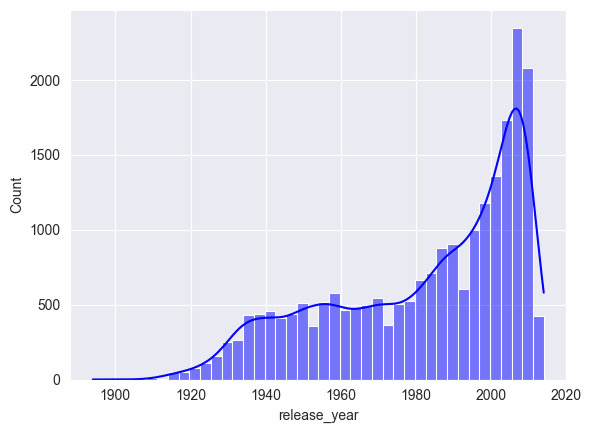

In [93]:
# plot the movie counts by year
_ = sns.histplot(df.release_year, kde=True, color='blue', label='treated')

As our analysis relies mostly on graphs and performing the analysis on the whole data (~ hundred years) might not be computationally feasible nor statistically reasonable, we decided to **continue the analysis on decade basis**. In other words, when generating the graphs, we'll generate one graph for every decade and perform correlation analysis on every decade separately.

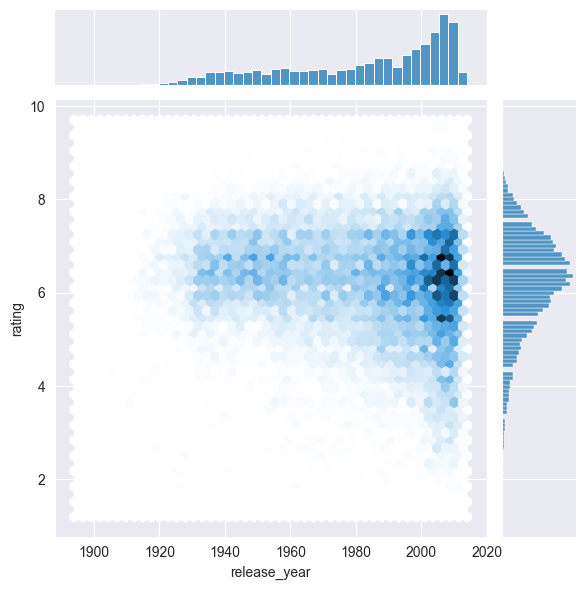

In [94]:
# let's see compare the IMDB rating with the year
_ = sns.jointplot(data=df, x='release_year', y='rating', kind='hex')

We see that the IMDB ratings are almost normally distributed between 2 and 9. Interestingly, older movies tend to have less low scores than the newer ones. 

## 2. Theory of Centrality Metrics <a class="anchor" id="theory"></a>

Our aim is to somehow quantify "being at the intersection". Most natural way of looking at it is network graphs. With the following examples, we will introduce the two measures that we’re going to use for quantifying it: **degree** and **betweenness**.

### 2.1 Betweenness <a class="anchor" id="betweenness"></a>

If you take all pairs of nodes from the graph and find the shortest paths between them, then betweenness centrality for a certain node is *the percentage of the shortest paths that go through the node*. To illustrate that, let's make an example graph and see if it works in practice.

In [95]:
G = nx.Graph()

# let's define edges
edges = [
    ('a', 'b'), ('a', 'c'), ('a', 'd'), ('c', 'd'), ('c', 'e'), ('b', 'e'),
    ('f', 'e'), ('f', 'h'), ('f', 'g'), ('g', 'h'), ('b', 'd'), ('i', 'g'),
    ('i', 'f'), ('h', 'e'), ('g', 'e')
]

for node_1, node_2 in edges:
    G.add_edge(node_1, node_2)

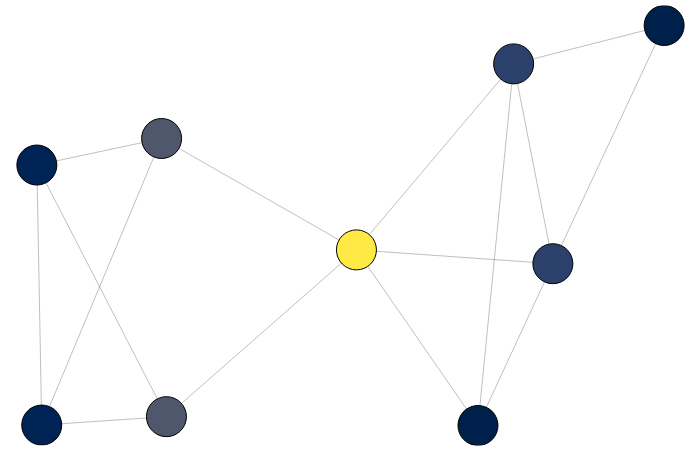

In [96]:
figure_kwargs = {
    'width': 700,
    'height': 450,
    'tooltips': [("betweenness", "@betweenness{0.00}")]
}

plot = plot_example_graph(G, 'betweenness', **figure_kwargs)
get_screenshot_as_png(plot)

The graph below is visualised so that the lighter nodes have higher betweenness. As you can see, the node that sits at the intersection clearly has higher betweenness measure than others. Thus, betweenness measure works well with clustered graphs and we have successfully quantified “being at the intersection” for those kinds of graphs. Following the theory from the book we mentioned before, the node/movie at the intersection **should have higher success compared to others**. 

### 2.1 Degree <a class="anchor" id="degree"></a>

What if we don’t have such clear clusters, but rather have a big chunk of quite similar movies and then some outliers? Let's generate data for this and look at it visually.

In [97]:
degree_graph = nx.Graph()

# let's define edges for a simple graph
edges = [
    ('b', 'o'), ('f', 'u'), ('a', 'b'), ('a', 'c'), ('a', 'd'), ('a', 'e'), 
    ('a', 'f'), ('b', 'c'), ('b', 'd'), ('b', 'e'), ('c', 'd'), ('c', 'e'),
    ('f', 'c'), ('f', 'd'), ('f', 'e'), ('g', 'b'), ('g', 'd'), ('g', 'f')
]

# add edges to the graph
for node_1, node_2 in edges:
    degree_graph.add_edge(node_1, node_2)

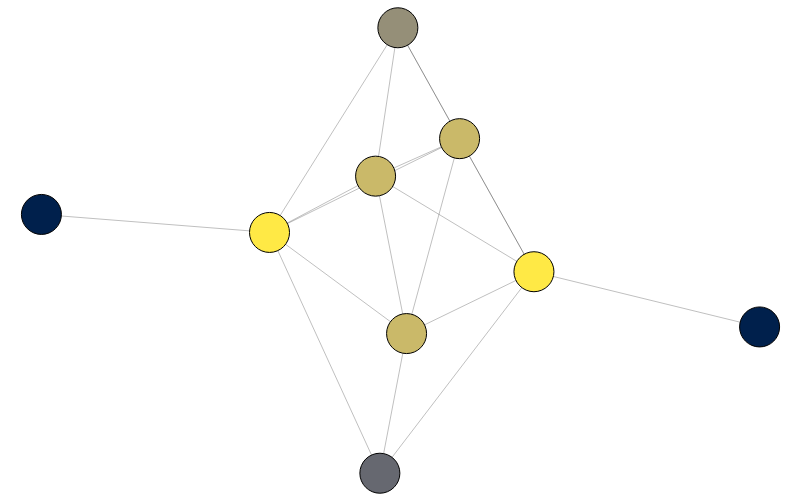

In [98]:
figure_kwargs = {
    'width': 800,
    'height': 500,
    'tooltips': [("degree", "@degree{0.00}"), ("betweenness", "@betweenness{0.00}")]
}

plot = plot_example_graph(degree_graph, color_attribute='degree', **figure_kwargs)
get_screenshot_as_png(plot)

In this sort of graph betweenness measure doesn't help us too much as it will be very low for most of the nodes (especially in bigger graphs). We don’t really have nodes that act as bridges between clusters and sit at the intersections. In that case, let’s redefine the Medici effect in the movie industry a bit and say that the most successful movies will be the ones that **have taken ideas from many other movies and thus are connected to the biggest possible number of other nodes**. This is exactly what the degree measure quantifies. The graph below has generated so that the color depicts the degree of the node.

## 3. Creating the Network Graphs <a class="anchor" id="creating-network"></a>

Now that we have settled the theory, we can start generating graphs. We will be using two different approaches that will be explained more in detail below:

1. **embedding**;
2. **genres**.

Notice that some of the steps below require significant computational resources. As Google Colab was more reasonable place for this, the more difficult steps were done in separate notebooks using Colab and data was saved to JSON / pickle files for later use. There will always be a reference to the corresponding notebook.

### 3.1 Embedding Approach <a class="anchor" id="embeddings"></a>

The embedding consists of 3 main steps that include:

- movie plots -> embeddings
- embeddings -> similarities
- similarities -> graphs

#### Plots to Embeddings 

First, we’ll use an embedding model [E5-large-v2](https://huggingface.co/intfloat/e5-large-v2) that takes the plot of the movie as an input and converts it into normalized feature vector with embedding size of 1024. As doing it locally for all the movies would be computationally too heavy, process is described in notebook [embeddings.ipynb](notebooks/embeddings.ipynb) and here we simply import the embeddings from JSON for illustration.

In [99]:
embeddings_dict = get_embeddings_from_json(2010, approach='embedding')
embeddings_dict[29054788].shape

(1024,)

As you can see, we saved the embeddings with wikipedia_id as there might be several movies with the same name from different years.

#### Embeddings to Similarities

As the embeddings are nicely normalized to unit vectors, we can simply use dot product to calculate cosine similarity of the two vectors. Due to combinatorial explosion, we calculated all the combinations for every decade again on Colab and you can see the methodology in [similarities.ipynb](notebooks/similarities.ipynb). Here we simply load the dictionary from JSON.

In [100]:
similarity_dict = get_similarities_from_json(2010, approach='embedding')

similarity_df = get_similarity_df(df.set_index('wikipedia_id'), similarity_dict,  20)
similarity_df.similarity = similarity_df.similarity * 100

similarity_df.head(5)

,movie_1,movie_2,similarity
0,Men in Black 3,The Runaways,72.613924
1,Men in Black 3,Guzaarish,71.855634
2,Men in Black 3,Afghan Luke,75.025985
3,Men in Black 3,Pig,74.837536
4,Men in Black 3,Husbands in Goa,72.035114


In similarity_df we have all possible movies with their corresponding similarities for the previous decade. We can verify if the similarities look reasonable for the naked eye by plotting some of them to similarity matrix.

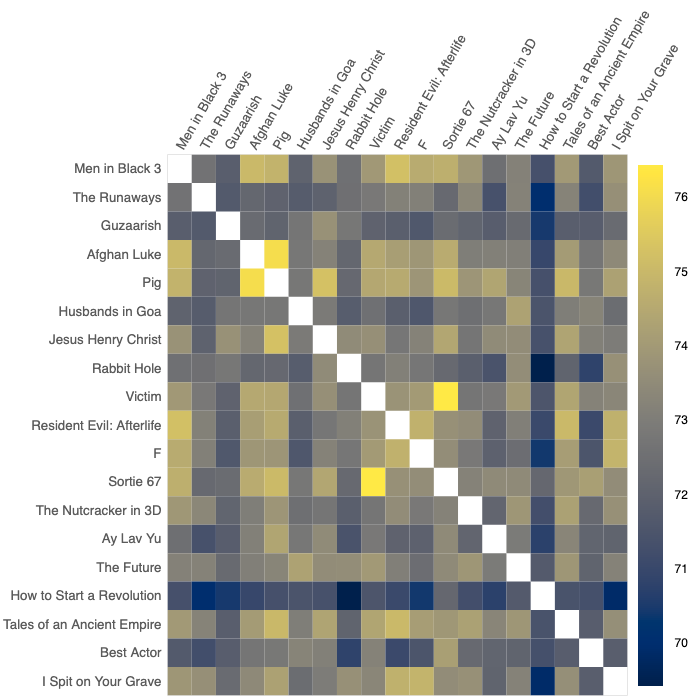

In [101]:
plot = plot_similarity_matrix(similarity_df, width=700)
get_screenshot_as_png(plot)

[Sortie 67](https://www.imdb.com/title/tt1651916/) and [Victim](https://s.media-imdb.com/title/tt1684564/?ref_=nm_flmg_t_1_msdp) both talk about witnessing a brutal murder, so it makes sense to qualify them as similar. On the other hand, [How to Start a Revolution](https://www.imdb.com/title/tt1956516/) is not too similar to any other movie. This is expected as it’s a biographical documentary, whereas all the others are based on fiction. It is especially different from [Rabbit Hole](https://www.imdb.com/title/tt0935075/?ref_=nv_sr_srsg_3_tt_7_nm_1_q_rabbit%2520h), which talks about a happy couple whose life is turned upside down after their young son dies in an accident. Thus, it seems that the embedding model has bone a decent job.

#### Similarities to Graphs

Once we have all possible combinations of similarities, we want to create an edge between all the movies for which the similarity is higher than a certain threshold. Although, we have done this in a separate notebook ([graphs.ipynb](notebooks/graphs.ipynb)), we will illustrate the process using year 2012.

In [102]:
# filter the similarity dictionary to contain only values from 2012
all_ids = list(set(itertools.chain(*similarity_dict.keys())))
wanted_ids = df[df.release_year == 2012].wikipedia_id.unique().tolist()
wanted_combinations = list(itertools.combinations(set(wanted_ids), 2))

similarity_dict_2012 = {}

for movie_1, movie_2 in wanted_combinations:
    try:
        similarity_dict_2012[(movie_1, movie_2)] = similarity_dict[(movie_1, movie_2)]
    except KeyError:
        similarity_dict_2012[(movie_2, movie_1)] = similarity_dict[(movie_2, movie_1)]

<AxesSubplot:title={'center':'Distribution of similarity values'}, ylabel='Frequency'>

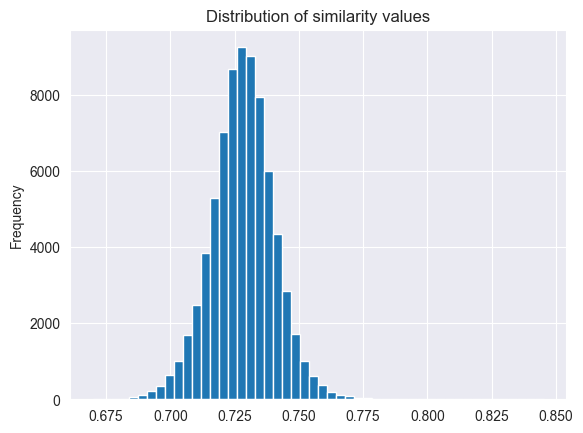

In [103]:
# check the distribution of similarity values
similarity_values = list(similarity_dict_2012.values())
pd.Series(similarity_values).plot.hist(bins=50, title='Distribution of similarity values')

In [104]:
# show descriptive statistics
descriptive_stats = pd.Series(similarity_values).describe()
descriptive_stats

count    75078.000000
mean         0.728260
std          0.012316
min          0.669865
25%          0.720608
50%          0.728393
75%          0.735918
max          0.845306
dtype: float64

The values are normally distributed and in order to keep it simple, let’s set the limit to **75% percentile**. This way we will have enough connected nodes, but not fully connected graph, which we clearly don't want.

In [105]:
similarity_threshold = descriptive_stats['75%'] 

# generate nodes df and add all the pairs with similarity
similarity_mat = [[key[0], key[1], value] for key, value in similarity_dict_2012.items()]
nodes_df = pd.DataFrame(similarity_mat, columns=['Source', 'Target', 'Weight']) 

# filter based on 75th percentile
nodes_df = nodes_df[nodes_df.Weight > similarity_threshold]

G = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')

In [106]:
G.number_of_nodes(), G.number_of_edges()

(386, 18770)

As we have now generated a graph based on the similarity threshold, we can add additional features to the graph. Notice that since Bokeh library is used for web based data story and it offers great dynamic graphs, here we simply plot the screenshot, which will not be that informative statically.

In [107]:
# use helper function to add main features and measures
# rating, release year, name, wikipedia_id, betweenness, degree
add_default_attributes(G, df)

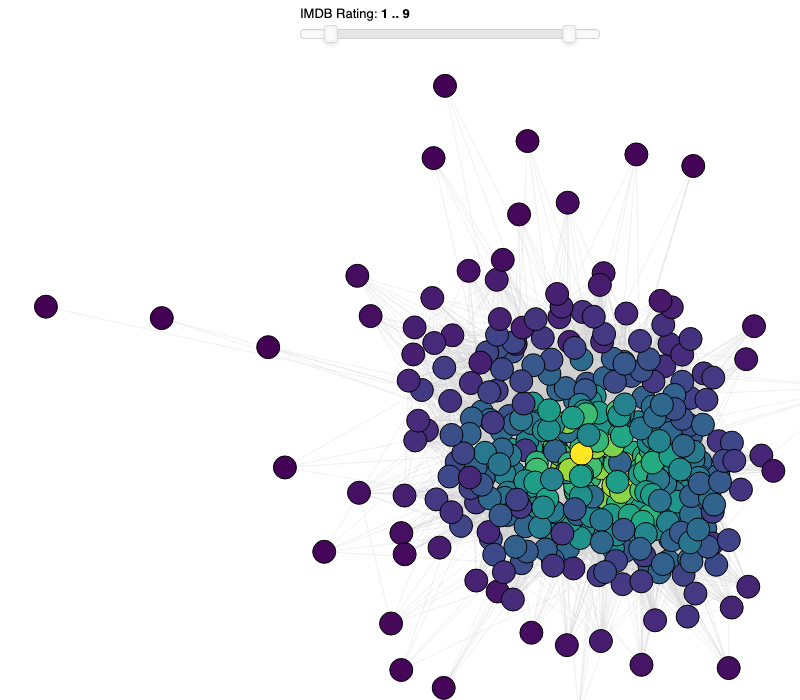

In [108]:
layout = plot_bokeh_graph(G, size_attribute=16, sizing_mode='stretch_width', height=700, width=900)
get_screenshot_as_png(layout)

We have only one big cluster with some movies on the outskirts. This is exactly one of the situations we described above and thus use degree to color the nodes (the lighter the color, the higher the degree). The size of the node is dependent on the IMDB rating of the movie (the bigger the node, the higher the rating). As we have only one big cluster, then the question to ask when coming back to the research problem is “whether the movies with higher degree are more successful”. In other words, we should see that the lighter nodes are bigger. From the visual inspection it is **really hard to tell if there is any association**. There are bigger nodes (higher rated → more successful) at the outskirts as well as in the middle of the cluster. It might even be that the bigger clusters tend to be at the outskirts.

### 3.2 Genres <a class="anchor" id="genres"></a>

The second approach includes using genres as the main input for forming the graphs. We first use raw genres for graph generation and then take a bit more tailored approach.

#### 3.2.1 Raw Genres

When looking at the data, we saw that there are movies with several genres. We will first look at the statistics and then come up with solution for forming a graph using them. Let's first see how many genres movies tend to have.

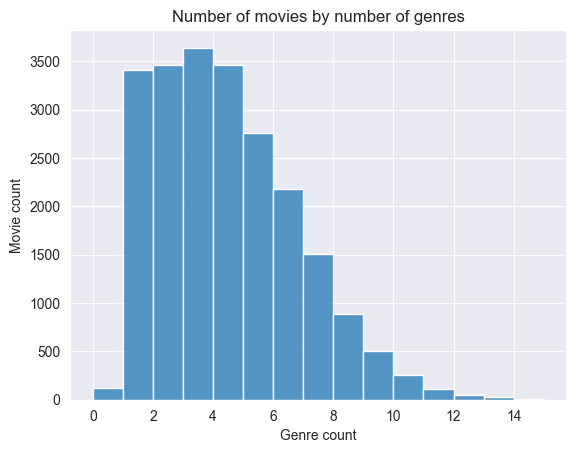

In [109]:
# use lambda to get the length of genre list
num_genres = df.genres.apply(lambda x: len(x)).rename('genre_count')
ax = sns.histplot(data=num_genres, bins=np.arange(0, 16, 1))

plt.xlabel('Genre count')
plt.ylabel('Movie count')
_ = plt.title('Number of movies by number of genres')

The distribution is heavily skewed. Most of the movies have 1-5 genres, but there might be as many as 17 or some even without any of them. Let's ignore the problems for now and see, what are the most popular ones.

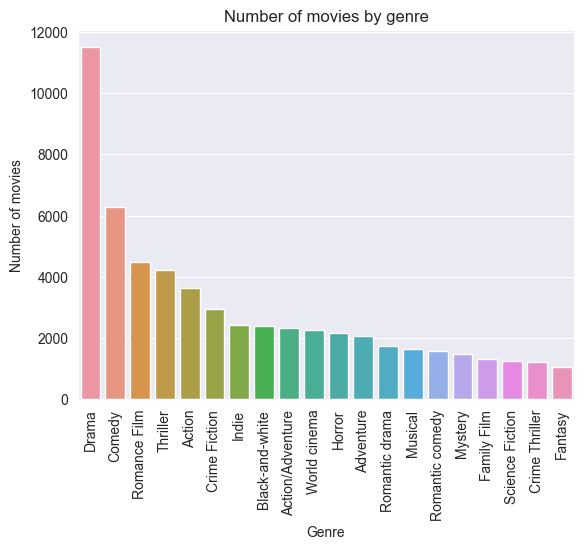

In [110]:
# look at only the "biggest" genres
count_min = 1000
genre_count = df.genres.explode().value_counts()
popular_genres = genre_count[genre_count > count_min]

# plot the count of each genre
sns.barplot(x=popular_genres.index, y=popular_genres.values)

plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of movies')
_ = plt.title('Number of movies by genre')

Drama tends to be by far the most popular genre. Although, we visualised only the most popular genres, it is clear that there will be heavy tail and many genres with only couple of movies. We will come back to these problems, but for now, we will generate the graph so that movies will be neighbours if they have at least one common genre.

In [111]:
# generate empty graph
genre_graph = nx.Graph()

# use year 2012
year_df = df[df.release_year == 2012]

# add edges based on the existance common of genres
for idx_1 in range(len(year_df)):
    for idx_2 in range(idx_1 + 1, len(year_df)):
        movie_1 = year_df.iloc[idx_1]
        movie_2 = year_df.iloc[idx_2]

        if set(movie_1.genres).intersection(movie_2.genres):
            genre_graph.add_edge(movie_1.wikipedia_id, movie_2.wikipedia_id)

In [112]:
# use helper function to add main features and measures
# rating, release year, name, wikipedia_id, betweenness, degree
genre_graph = add_default_attributes(genre_graph, year_df)

# adjusted node size 
ratings = nx.get_node_attributes(genre_graph, "rating").items()
adjusted_node_size = dict((key, value * 3.3) for key, value in ratings)
nx.set_node_attributes(genre_graph, name='adjusted_node_size', values=adjusted_node_size)

# annoying thingy that must be done to convert nx graph into Bokeh one
mapping = dict((n, i) for i, n in enumerate(genre_graph.nodes))
genre_graph = nx.relabel_nodes(genre_graph, mapping)

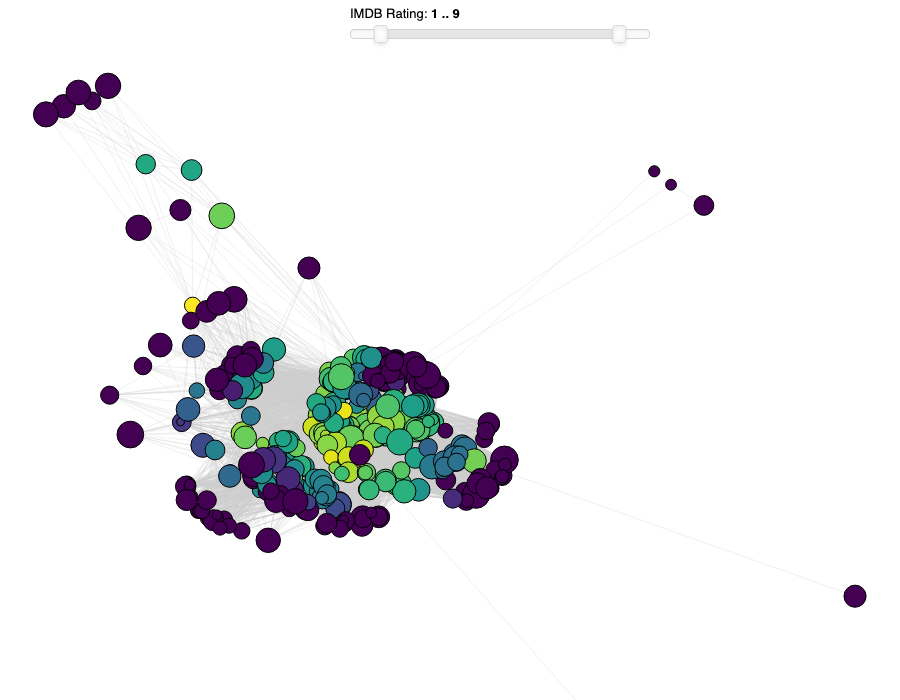

In [113]:
# let's use log betweenness to color the nodes
layout = plot_bokeh_graph(genre_graph, color_attribute='log_betweenness', height=700, width=900)
get_screenshot_as_png(layout)

Now we have some distinct clusters based on the color (betweenness). It is, however, still really hard to tell if more popular movies tend to have lighter (higher betweenness) or darker color (lower betweenness).

### 3.2.2 Custom Genres & Themes

The first approach included several problems, that we briefly mentioned before, but will come back to them here. While keeping in mind the last two histograms, let's print all possible genres we have.

In [114]:
# Unique genres
unique_genres = set(itertools.chain(*df.genres.tolist()))
print(f'We have {len(unique_genres)} unique genres.')
print(f'All genres: {unique_genres}')

We have 347 unique genres.
All genres: {'Biopic [feature]', 'Vampire movies', 'Interpersonal Relationships', 'Nature', 'Giallo', 'Comedy horror', 'Period piece', 'Gay pornography', 'World cinema', 'Superhero movie', 'Horror', 'Ninja movie', 'Cold War', 'Beach Party film', 'Monster movie', 'Northern', 'Buddy Picture', 'Comedy of Errors', 'Historical drama', 'Sports', 'Gay Themed', 'Fictional film', 'Live action', 'Education', 'Buddy film', 'Anime', "Children's", 'Glamorized Spy Film', 'Art film', 'Indian Western', 'Film', 'Essay Film', 'Cult', 'Musical Drama', 'Social problem film', 'Slice of life story', 'Avant-garde', 'Punk rock', 'Mockumentary', 'Film & Television History', 'Gangster Film', 'Coming of age', 'Prison', 'Film adaptation', 'Spaghetti Western', 'Swashbuckler films', 'Gross-out film', 'Biker Film', 'Boxing', 'Women in prison films', 'Creature Film', 'Heaven-Can-Wait Fantasies', 'Acid western', 'Biographical film', "Children's Entertainment", 'Feature film', 'War effort', '

#### Limitations

##### Excessive and Redundant Genres

Our current dataset suffers from an overabundance of genres. Many of these, such as "Black-and-white" or "Animation," do not directly relate to the plot but rather to the style or technique of the movie. The presence of subgenres like "Romantic Drama" complicates the genre landscape, as they often represent a mixture of primary genres, making it difficult to maintain clear distinctions.

##### Skewed Genre Distribution

The genre distribution in our dataset is heavily skewed, with most movies categorized under 1-6 genres, while some have as many as 16 genres. This uneven distribution poses a challenge for consistent and meaningful genre analysis.

##### Entanglement of Popular Genres

Even among the most popular genres, we observe unnecessary entanglement. For instance, while "Comedy" and "Drama" are distinct in the emotions they evoke, genres like "Science-Fiction" or "Crime" often overlap with others such as "Drama" and "Comedy," serving more as settings or themes rather than standalone genres.

#### Splitting Genres and Themes

To enhance the accuracy of our movie classification, we've decided to differentiate between 'genres' and 'themes' for our model's predictions. This distinction allows us to capture both the emotional tone and the narrative setting of each movie more effectively.

**Genres** are selected based on their association with specific emotions or feelings. Our chosen genres are:
- Drama
- Comedy
- Action
- Horror
- Romance
- Thriller
- Adventure
- Documentary

**Themes**, on the other hand, are defined by their focus on particular settings or scenarios. The themes we include are:

- Science-Fiction
- Crime
- Fantasy
- War
- Mystery
- History
- Western
- Family

This bifurcation into genres and themes aims to provide a more nuanced classification, recognizing that the emotional impact of a movie (genre) and its narrative backdrop (theme) are distinct yet equally important aspects of its identity.

The split is also necessary from a model perspective because otherwise the model might be inclined to predict themes rather than genres as they are more related to the plot, which is the only input for the model.

#### Advantages of a New Genre System

Now that we have selected specific genres we can use a Large Language Model (LLM) to predict the probability that certain movie (or its plot description to be precise) belongs to certain genre and theme. By choosing specific genres for the LLM to focus on, we can bypass the issues of an overabundance of genres and the confusion caused by subgenres. This targeted approach enables the LLM to predict genre probabilities accurately based on movie plots, ensuring that the classification is both relevant and plot-centric. Moreover, it helps in normalizing the skewed distribution of genres in our dataset.

In [115]:
# list of the selected genres and themes
genre_labels = ['Drama', 'Comedy', 'Action', 'Horror', 'Romance', 'Thriller', 'Adventure', 'Documentary']
theme_labels = ['Science-Fiction', 'Crime', 'Fantasy', 'War', 'Mystery', 'History', 'Western', 'Family']

As using an LLM is a computationally heavy task, you can take a look at the process in [embeddings.ipynb](notebooks/embeddings.ipynb), where we saved all the predictions from LLM into JSON files that we can now use. Notice that we let the model predict genres and themes separately and then tried the approach, where we concatenated the lists and let the model predict the probabilities from the joined genre and theme list.

In [116]:
# get probabilities for the last decade
probabilities = get_classification_from_json(2010)

To validate our assumption that separating genres and themes will enhance the model's performance, we've designed a classification experiment with a three-pronged approach. First, we classify movies using only genre labels to observe the probability distributions. Second, we repeat the process using only theme labels. Finally, we combine both genre and theme labels in the classification. Our comparison will focus on examining how the genre probability distributions in the first and third scenarios differ, as well as how the theme probability distributions in the second and third scenarios vary.

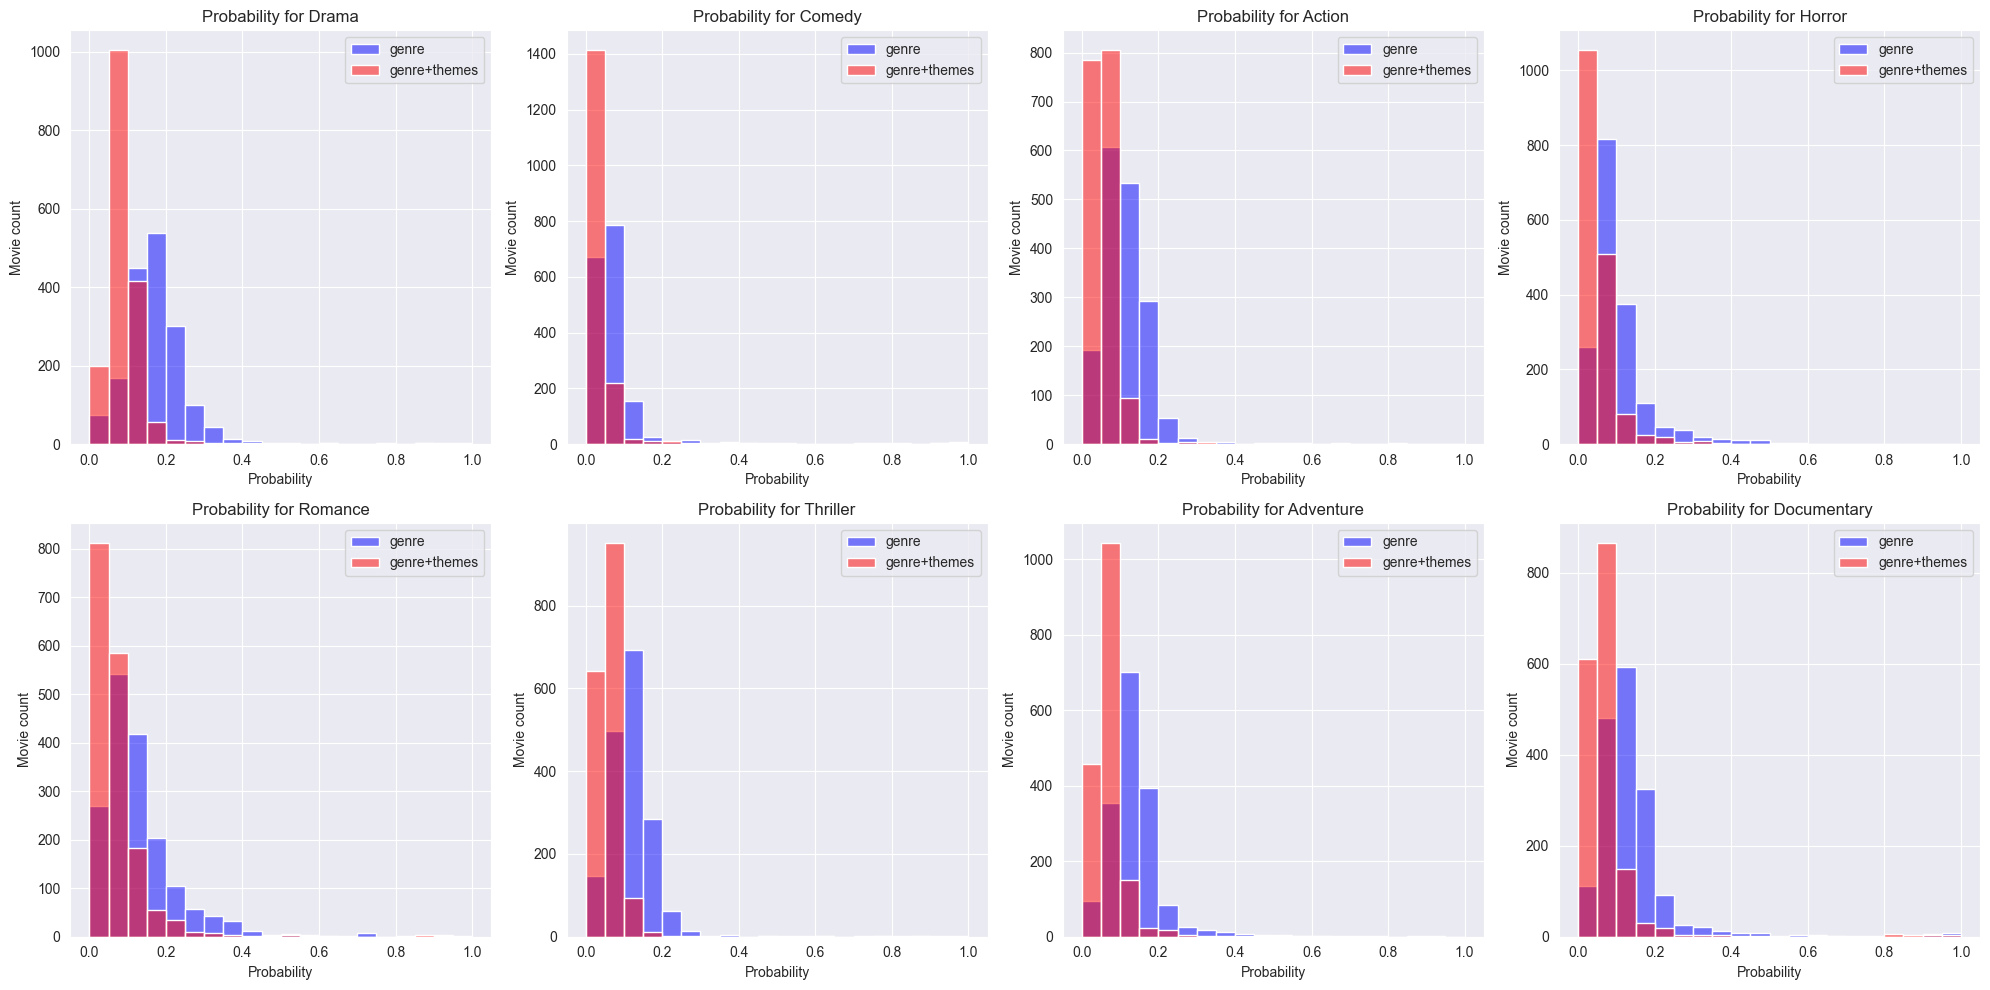

In [117]:
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, genre in enumerate(genre_labels):

    genre_probs = [probabilities[movie]['genres']['scores'][probabilities[movie]['genres']['labels'].index(genre)] for movie in probabilities.keys()]
    full_probs = [probabilities[movie]['full']['scores'][probabilities[movie]['full']['labels'].index(genre)] for movie in probabilities.keys()]

    sns.histplot(genre_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='blue', label='genre', alpha=0.5)
    sns.histplot(full_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='red', label='genre+themes', alpha=0.5)
    axes[i].set_title(f'Probability for {genre}')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Movie count')
    axes[i].legend()

plt.tight_layout()
plt.show()

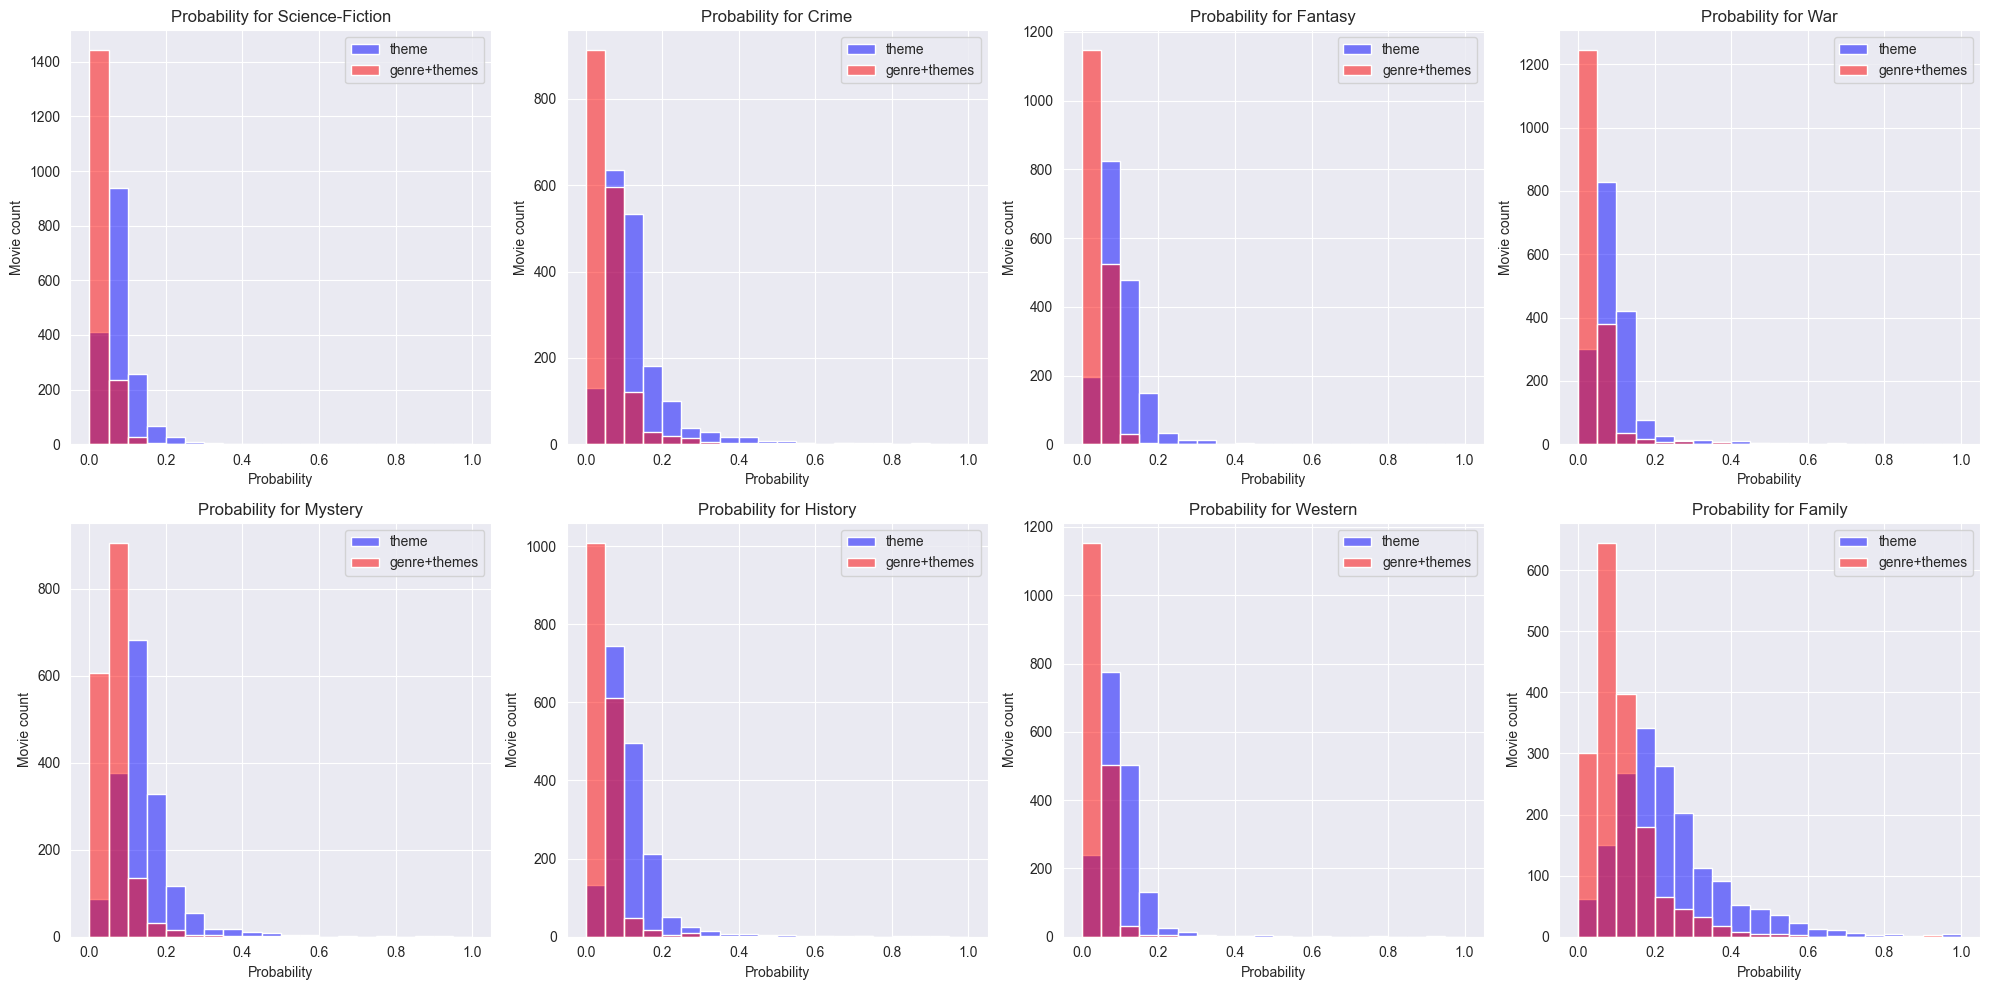

In [118]:
n_rows = 2
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, genre in enumerate(theme_labels):
    theme_probs = [probabilities[movie]['themes']['scores'][probabilities[movie]['themes']['labels'].index(genre)] for movie in probabilities.keys()]
    full_probs = [probabilities[movie]['full']['scores'][probabilities[movie]['full']['labels'].index(genre)] for movie in probabilities.keys()]

    sns.histplot(theme_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='blue', label='theme', alpha=0.5)
    sns.histplot(full_probs, bins=np.arange(0, 1.05, 0.05), ax=axes[i], color='red', label='genre+themes', alpha=0.5)
    axes[i].set_title(f'Probability for {genre}')
    axes[i].set_xlabel('Probability')
    axes[i].set_ylabel('Movie count')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [142]:
def get_probability_for(movie: str, probabilities: dict, topic: str) -> float:
    """
    Get probability for the correct movie with specified topic.
    
    :param movie: wikipedia_id
    :param probabilities: the full dict with classification results
    :param topic: either genres or themes
    :return: probability
    """
    correct_list = probabilities[movie]['full']['scores']
    id = probabilities[movie]['full']['labels'].index(topic)
    return correct_list[id]

In [144]:
# Let's compare the summed probabilities distribution of genres with those of themes in the same movie

summed_genres = []
summed_themes = []

for movie_id in probabilities.keys():
    summed_genres.append(sum([get_probability_for(movie_id, probabilities, genre) for genre in genre_labels]))
    summed_themes.append(sum([get_probability_for(movie_id, probabilities, theme) for theme in theme_labels]))


sns.histplot(summed_genres, bins=np.arange(0, 1.05, 0.05), color='blue', label='genre', alpha=0.5)
sns.histplot(summed_themes, bins=np.arange(0, 1.05, 0.05), color='red', label='theme', alpha=0.5)
plt.xlabel('Summed probability')
plt.ylabel('Movie count')
plt.title('Summed probabilities for genres and themes')
plt.legend()

KeyboardInterrupt: 

There will always be some sort of imbalance between the genres and the themes which should not appear as they are different dimensions of classifying a movie. However, when we are not splitting them the model will be more inclined to predict themes as they are more related to the plot, which is the only input for the model.

#### Graph Creation

Now that we have the probabilities for each movie we can look at them as embeddings and use a similar approach as above in order to create the graph. Notice that in this notebook we illustrate the process with year 2012. The whole similarity calculating process can be found from [similarities.ipynb](notebooks/similarities.ipynb). Here we try two different approaches for embeddings: 

1. Use the separate predictions for genres and themes, concatenate and normalize the lists.
2. Use the predictions directly for the full list of genres and themes that we got from the model.

In [120]:
# helper functions for getting embeddings and computing similarities

def embedding_split(movie: dict):
    """Get the genres and themes from the dict, normalize and return feature vector."""
    labels = movie['genres']['labels'] + movie['themes']['labels']
    scores = movie['genres']['scores'] + movie['themes']['scores']
    
    # sort the labels and reorder the scores accordingly
    _, scores = zip(*sorted(zip(labels, scores)))
    
    # normalize the embedding
    embedding = np.array(scores)
    norm_embedding = embedding / np.linalg.norm(embedding)

    return norm_embedding.squeeze()

def embedding_full(movie: dict):
    """Use LLM prediciton for the full list of genres+themes and sort them alphabetically."""
    labels = movie['full']['labels']
    scores = movie['full']['scores']
    
    # sort the labels and reorder the scores accordingly
    labels, scores = zip(*sorted(zip(labels, scores)))
    return np.array(scores)

def compute_similarity(probabilities: dict, get_embedding: Callable) -> float:
    """
    Compute similarity based on probability dict and function for getting embedding.
    
    :param probabilities: for all possible movies
    :param get_embedding: function depending on the use case
    :return: cosine similarity
    """
    similarity = {}

    for movie_1, movie_2 in tqdm(itertools.combinations(probabilities.keys(), 2)):
        embedding_1 = get_embedding(probabilities[movie_1])
        embedding_2 = get_embedding(probabilities[movie_2])
        similarity[(movie_1, movie_2)] = np.dot(embedding_1, embedding_2)

    return similarity

In [121]:
# filter the similarity dictionary to contain only values from 2012
wanted_ids = year_df.wikipedia_id.tolist()
probabilities_2012 = {str(key): probabilities[str(key)] for key in wanted_ids}

In [122]:
# calculate similarities using the two approaches
split_similarity = compute_similarity(probabilities_2012, embedding_split)
full_similarity = compute_similarity(probabilities_2012, embedding_full)

75078it [00:02, 35864.35it/s]
75078it [00:00, 75722.61it/s]


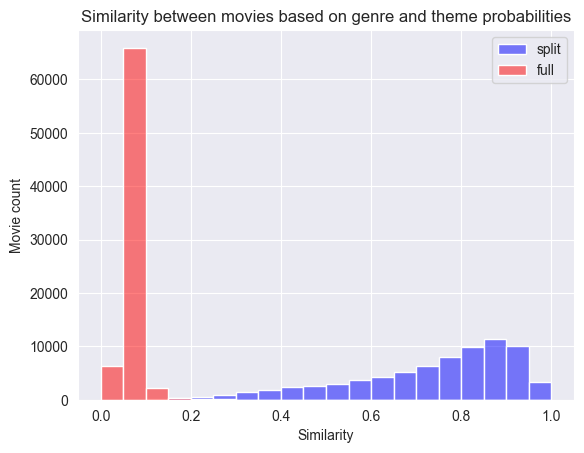

In [123]:
# plot the distributions of similarity scores
sns.histplot(
    list(split_similarity.values()), 
    bins=np.arange(0, 1.05, 0.05), 
    color='blue', label='split', alpha=0.5
)
sns.histplot(
    list(full_similarity.values()), 
    bins=np.arange(0, 1.05, 0.05), 
    color='red', label='full', alpha=0.5
)

plt.xlabel('Similarity')
plt.ylabel('Movie count')
plt.title('Similarity between movies based on genre and theme probabilities')
plt.legend()

Here we see another motivation of splitting between genres and themes, as the similarity distribution is wider when we use the split version of genres and themes. Now we can finally use the split approach to generate a graph.

In [124]:
descriptive_stats = pd.Series(list(split_similarity.values())).describe()
similarity_threshold = descriptive_stats['75%']

# generate nodes df and add all the pairs with similarity
similarity_mat = [[key[0], key[1], value] for key, value in split_similarity.items()]
nodes_df = pd.DataFrame(similarity_mat, columns=['Source', 'Target', 'Weight'])

# filter based on 75th percentile
nodes_df = nodes_df[nodes_df.Weight > similarity_threshold]

# generate the graph
genre_theme_graph = nx.from_pandas_edgelist(nodes_df, 'Source', 'Target', 'Weight')

In [125]:
# use helper function to add main features and measures
# rating, release year, name, wikipedia_id, betweenness, degree
genre_theme_graph = add_default_attributes(genre_theme_graph, year_df)

# adjusted node size 
ratings = nx.get_node_attributes(genre_theme_graph, "rating").items()
adjusted_node_size = dict((key, value * 3.3) for key, value in ratings)
nx.set_node_attributes(genre_theme_graph, name='adjusted_node_size', values=adjusted_node_size)

mapping = dict((n, i) for i, n in enumerate(genre_theme_graph.nodes))
genre_theme_graph = nx.relabel_nodes(genre_theme_graph, mapping)

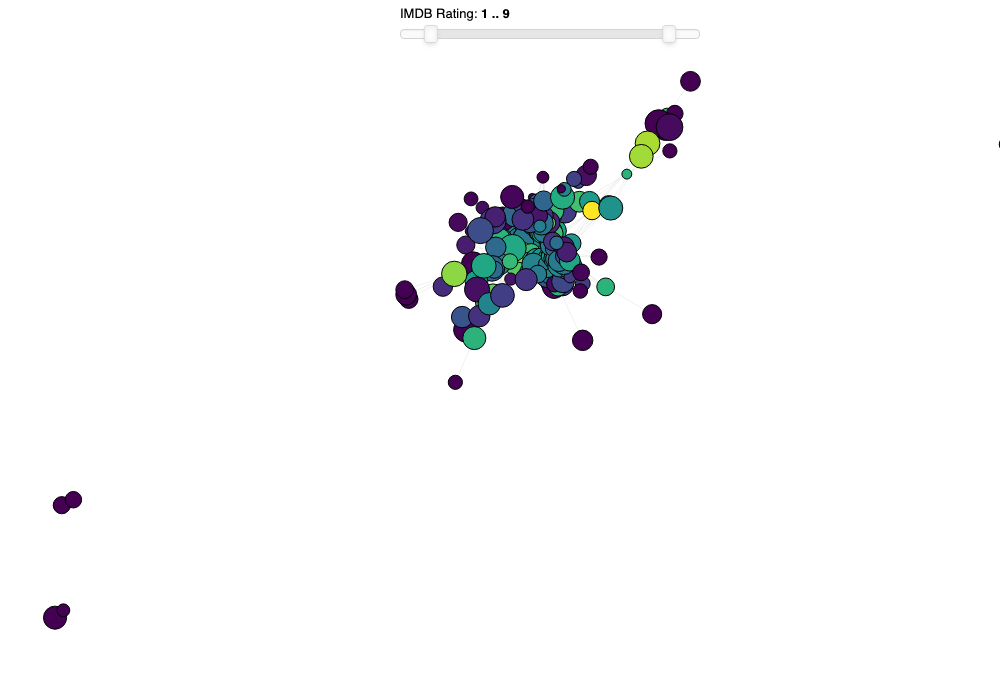

In [126]:
layout = plot_bokeh_graph(genre_theme_graph, color_attribute='log_betweenness', sizing_mode='stretch_width')
get_screenshot_as_png(layout)

## 4. Correlation Analysis <a class="anchor" id="correlation-analysis"></a>

The correlation analysis consist of two parts:

1. we first use simple Pearson correlation coefficient;
2. then we control for certain variables that might blur the initial results.

Based on the similarities we have generated the graphs with all the necessary features in the notebook [graohs.ipynb](notebooks/graphs.ipynb) that we can now import from pickle here.

### 4.1 Correlation without Controlling for Confounders <a class="anchor" id="corr-simple"></a>

We use the 3 graphs that we created and calculate correlation coefficients 4 different ways:
- **embedding approach**: IMDB rating vs degree
- **raw genre approach**: IMDB rating vs betweenness
- **custom genre approach**: IMDB rating vs betweenness
- **custom genre approach**: IMDB rating vs degree

Such choice was made due to several reasons. First, embedding approach generated a graph with one big cluster that would have really low betweenness measures for most of the nodes and wouldn't make sense. Raw genre approach relies heavily on the number of genres every node has and therefore, degree would not be reasonable to use. Last graph (custom genre approach) has some clusters, but not too obvious ones, so we would love to see the difference of the results when using degree and betweenness approach. 

In [127]:
# relate to the approaches described above
first = list(nx.get_node_attributes(G, 'degree').values())
second = list(nx.get_node_attributes(genre_graph, 'betweenness').values())
third = list(nx.get_node_attributes(genre_theme_graph, 'degree').values())
fourth = list(nx.get_node_attributes(genre_theme_graph, 'betweenness').values())

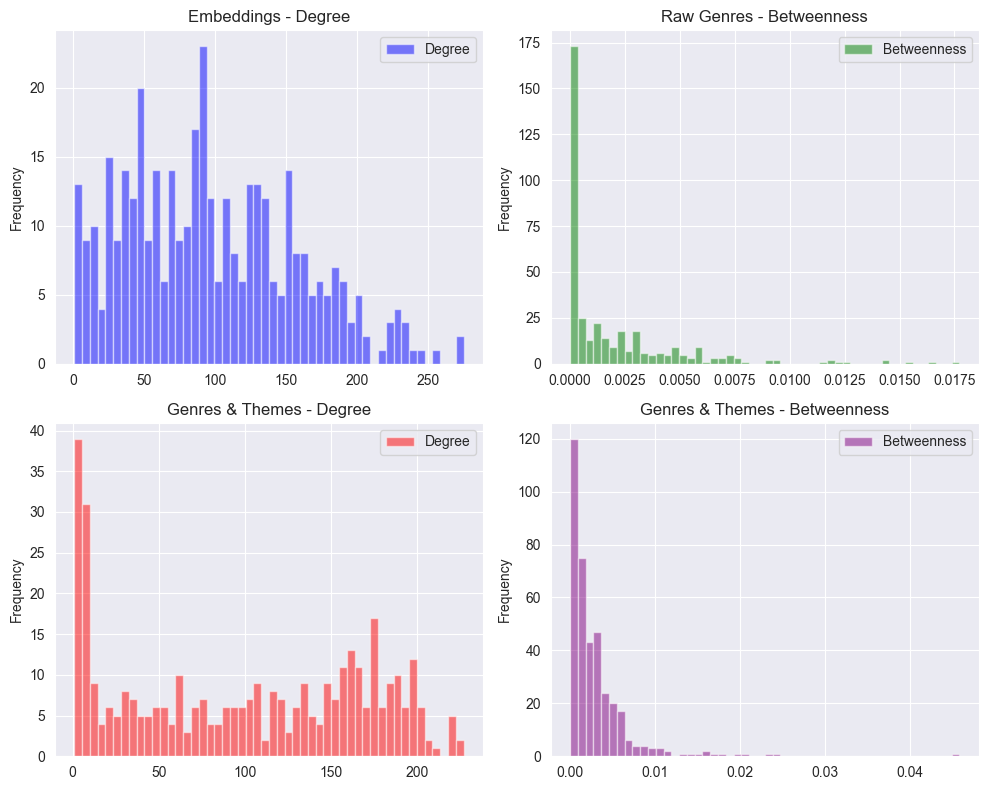

In [148]:
nbins = 50

# Create a 2x2 subplot for histograms
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot IMDB rating vs degree
axes[0, 0].hist(first, bins=nbins, alpha=0.5, color='blue', label='Degree')
axes[0, 0].set_title('Embeddings - Degree')

# Plot IMDB rating vs betweenness
axes[0, 1].hist(second, bins=nbins, alpha=0.5, color='green', label='Betweenness')
axes[0, 1].set_title('Raw Genres - Betweenness')

# Plot IMDB rating vs betweenness (second time)
axes[1, 0].hist(third, bins=nbins, alpha=0.5, color='red', label='Degree')
axes[1, 0].set_title('Genres & Themes - Degree')

# Plot IMDB rating vs degree (second time)
axes[1, 1].hist(fourth, bins=nbins, alpha=0.5, color='purple', label='Betweenness')
axes[1, 1].set_title('Genres & Themes - Betweenness')

# add legends and axis labels
for j, k in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    axes[j, k].legend(loc='upper right')
    axes[j, k].set_ylabel('Frequency')

# Add space between subplots
plt.tight_layout()

# Display the plot
plt.show()

As you can see from the histograms above, 3 out of 4 approaches have heavy tail and two of them clearly follow the power law. As **Pearson's correlation coefficient** is very sensitive to the outliers, we will then use **Spearman's rank correlation** for these three to make the analysis more robust.

In [129]:
# helper function of getting coefficients in the right format
def get_corr_string(x: pd.Series, y: pd.Series, method: Callable) -> str:
    """Format the correlation as coef (pvalue)."""
    coef = method(x, y)
    return f"{coef.statistic:.3f} ({coef.pvalue:.3f})"

In [130]:
# let's first get graphs, generate dfs and save them to lists for later use
decades = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]

embedding_dfs = []
raw_genre_dfs = []
custom_genre_dfs = []

col_names = [
    'embedding (degree)', 'raw genres (betweenness)', 
    'genres & themes (degree)', 'genres & themes (betweenness)'
]
correlation_df = pd.DataFrame(columns=col_names)

In [131]:
# get the graph and add necessary measures from graph to the df
for decade in decades:
    
    # initialise row for correlation df
    row = []
    
    # first approach
    G = get_graph_from_pickle(decade, approach='embedding')
    df_= merge_graph_to_df(df.set_index('wikipedia_id'), G, ['degree', 'betweenness']) 
    corr = get_corr_string(df_.rating, df_.degree, stats.pearsonr)
    
    row.append(corr)
    embedding_dfs.append(df_)
    
    # second approach
    G = get_graph_from_pickle(decade, approach='raw_genres')
    df_= merge_graph_to_df(df.set_index('wikipedia_id'), G) 
    corr = get_corr_string(df_.rating, df_.betweenness, stats.spearmanr)
    
    row.append(corr)
    raw_genre_dfs.append(df_)
    
    # third approach
    G = get_graph_from_pickle(decade, approach='custom_genres')
    df_= merge_graph_to_df(df.set_index('wikipedia_id'), G) 
    
    corr_deg = get_corr_string(df_.rating, df_.degree, stats.spearmanr)
    corr_bet = get_corr_string(df_.rating, df_.betweenness, stats.spearmanr)
    
    row.append(corr_deg)
    row.append(corr_bet)
    custom_genre_dfs.append(df_)
    
    correlation_df.loc[decade] = row

In [132]:
correlation_df

,embedding (degree),raw genres (betweenness),genres & themes (degree),genres & themes (betweenness)
1920,-0.076 (0.126),0.137 (0.005),0.073 (0.142),0.054 (0.272)
1930,-0.014 (0.609),0.179 (0.000),0.168 (0.000),0.091 (0.001)
1940,-0.083 (0.001),0.218 (0.000),0.204 (0.000),0.101 (0.000)
1950,-0.075 (0.002),0.095 (0.000),0.226 (0.000),0.105 (0.000)
1960,-0.066 (0.008),0.084 (0.001),0.201 (0.000),0.072 (0.004)
1970,-0.121 (0.000),0.084 (0.001),0.149 (0.000),0.090 (0.000)
1980,-0.104 (0.000),nan (nan),0.148 (0.000),0.057 (0.004)
1990,-0.120 (0.000),nan (nan),0.140 (0.000),0.061 (0.000)
2000,-0.135 (0.000),nan (nan),0.092 (0.000),0.076 (0.000)
2010,-0.143 (0.000),nan (nan),0.095 (0.000),0.062 (0.011)


While the first approach shows small but stable **negative correlation**, all other approaches have somewhat small **positive correlation**. This might depend on the approach applied for generating the graph. Although mostly statistically significant effect, there is high chance that it is simply noise. As the sample size is quite big, we could turn even the tiniest effects significant. Correlation coefficient below .2 are **too small to make stronger conclusions**.

In [133]:
# TODO: remove
from scripts.helpers import get_bokeh_table
table = get_bokeh_table(correlation_df.reset_index().rename(columns={'index': 'decade'}), 'corr')    

# show(table)

from bokeh.plotting import output_file, save
output_file('corr_table.html')
save(table)

'/Users/jan.kokla/Documents/EPFL/ada-2023-project-adaroundtheworld2023/corr_table.html'

For better understanding of the dynamics in embedding approach, let's use scatterplots with regression line.

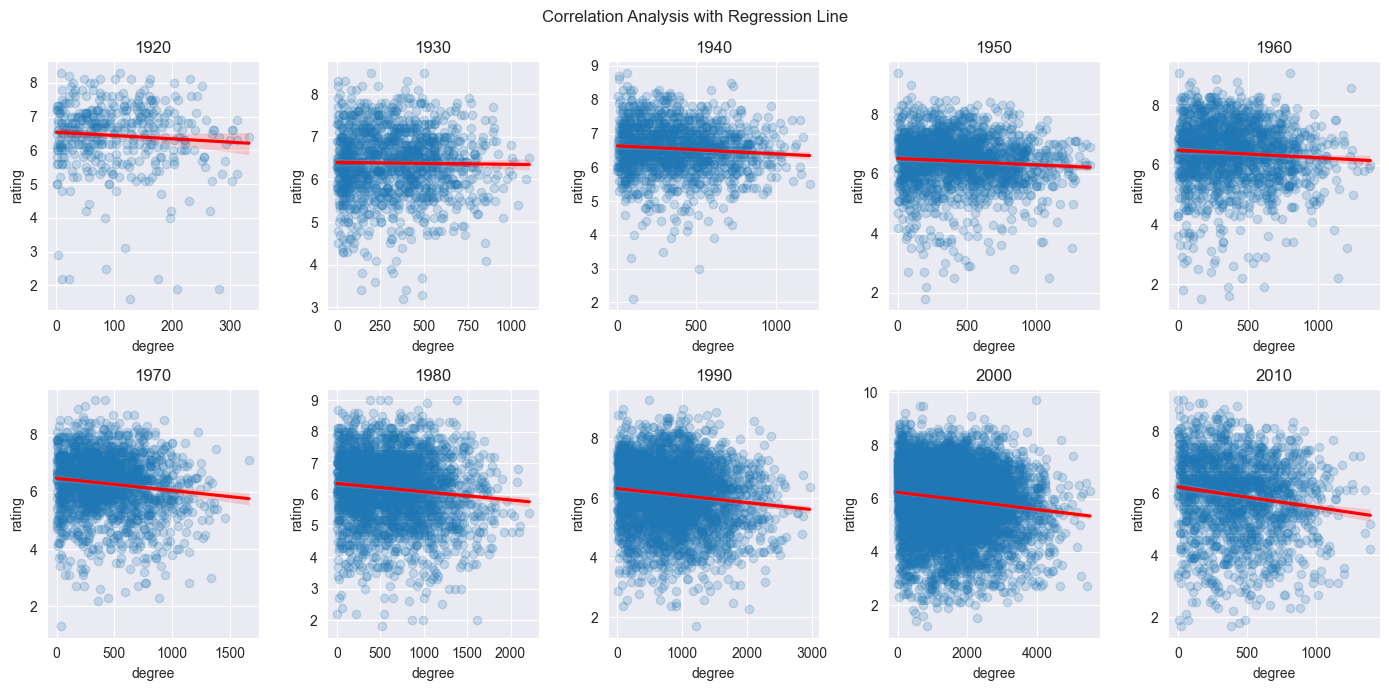

In [134]:
fig, axs = plt.subplots(2, 5, figsize=(14, 7))

decades_as_plot = np.array(decades).reshape(2, 5)
for i, ((row, col), decade) in enumerate(np.ndenumerate(decades_as_plot)):
    sns.regplot(
        embedding_dfs[i]['degree'], embedding_dfs[i]['rating'], 
        scatter_kws={'alpha': 0.2}, line_kws={'color': "r"}, ax=axs[row][col]
    )
    axs[row][col].set_title(str(decade))
    
fig.suptitle('Correlation Analysis with Regression Line')
plt.tight_layout();

### 4.2 Controlling for Confounders <a class="anchor" id="corr-controlled"></a>

Simple correlation might not give us too clear picture though as there are some other variables that might influence the association. For example:

- we know that some movies have more ratings than others;
- country of origin might influence the IMDB ratings;
- IMDB rating might also be depending on the genres of the movie.

In [135]:
def is_in_list(value: str):
    return pd.Series({category: 1 for category in value})

In [136]:
def get_partial_correlation_str(df: pd.DataFrame, x: str, y: str, method: str) -> str:
    """
    Calculate the correlation and convert it to string with r (p-value)
    
    :param df: with the data about movies
    :param x: x-attribute
    :param y: y-attribute
    :param method: of correlation, either "pearson" or "spearman"
    :return: string in the designated format
    """
    keep_cols = ['num_votes', x, y]
    
    country_dummies = df['countries'].apply(is_in_list).fillna(0, downcast='int')
    genre_dummies = df['genres'].apply(is_in_list).fillna(0, downcast='int')
    
    partial_corr_df = pd.concat([df[keep_cols], country_dummies, genre_dummies], axis=1)
    
    covar_cols = partial_corr_df.columns.tolist()
    covar_cols.remove(x)
    covar_cols.remove(y)
    
    res = pg.partial_corr(data=partial_corr_df, x=x, y=y, covar=covar_cols, method=method).round(3)
    return f"{res.iloc[0].r:.3f} ({res.iloc[0]['p-val']:.3f})"

In [137]:
partial_corr_df = pd.DataFrame(columns=col_names)

for decade in decades:
    
    row = []
    
    # embedding approach
    G = get_graph_from_pickle(decade, 'embedding')
    df_ = merge_graph_to_df(df.set_index('wikipedia_id'), G, ['degree', 'betweenness']) 
    corr = get_partial_correlation_str(df_, 'rating', 'degree', 'pearson')
    
    row.append(corr)
    
    # raw genre approach
    G = get_graph_from_pickle(decade, 'raw_genres')
    df_ = merge_graph_to_df(df.set_index('wikipedia_id'), G) 
    corr = get_partial_correlation_str(df_, 'rating', 'betweenness', 'spearman')
    
    row.append(corr)
    
    # custom genre & theme approach
    G = get_graph_from_pickle(decade, 'custom_genres')
    df_ = merge_graph_to_df(df.set_index('wikipedia_id'), G) 
    
    corr_deg = get_partial_correlation_str(df_, 'rating', 'degree', 'spearman')
    corr_bet = get_partial_correlation_str(df_, 'rating', 'betweenness', 'spearman')
    
    row.append(corr_deg)
    row.append(corr_bet)
    
    partial_corr_df.loc[decade] = row

In [138]:
partial_corr_df

,embedding (degree),raw genres (betweenness),genres & themes (degree),genres & themes (betweenness)
1920,-0.009 (0.874),-0.170 (0.003),-0.007 (0.898),-0.048 (0.404)
1930,0.023 (0.438),-0.086 (0.004),0.044 (0.138),-0.020 (0.498)
1940,-0.086 (0.002),0.008 (0.785),0.031 (0.273),-0.021 (0.447)
1950,-0.061 (0.015),-0.059 (0.019),0.059 (0.020),0.017 (0.490)
1960,-0.035 (0.203),-0.030 (0.274),0.083 (0.002),0.042 (0.127)
1970,-0.068 (0.009),-0.030 (0.274),0.043 (0.102),-0.000 (0.996)
1980,-0.037 (0.077),0.175 (0.000),0.043 (0.041),0.003 (0.883)
1990,-0.071 (0.000),-0.053 (0.004),0.015 (0.407),-0.012 (0.515)
2000,-0.017 (0.182),0.087 (0.000),0.046 (0.000),0.043 (0.001)
2010,-0.041 (0.123),-0.068 (0.009),0.048 (0.068),0.052 (0.049)


In [139]:
# TODO: remove
from scripts.helpers import get_bokeh_table

table = get_bokeh_table(partial_corr_df.reset_index().rename(columns={'index': 'decade'}), 'partial-corr')    

# show(table)

from bokeh.plotting import output_file, save
output_file('partial_corr_table.html')
save(table)

'/Users/jan.kokla/Documents/EPFL/ada-2023-project-adaroundtheworld2023/partial_corr_table.html'

Although, the mix of positive and negative correlations is now more confusing, the general picture became much more clear - **there is no linear dependency between “being at the intersection” and IMDB ratings**. The coefficients are so small that there is no doubt it is due to noise rather than anything else. When coming back to the original question “are movies that merge ideas from different genres/domains more successful”, we can say that based on the used approaches, there is no such relation.

## Summary  <a class="anchor" id="summary"></a>

Our story started with the “Medici effect”, the idea that different perspectives could increase the originality and lead to better outcome. We applied the idea to the movie industry and hypothesised that movies with different genres/ideas/motives would be more successful. To validate it, we converted the raw data of the movies into graphs using different approaches for more robustness. Based on graphs we calculated the measure of “being at the intersection”, which we represented with betweenness and degree centrality. Finally, we calculated correlation and controlled for some variables for further robustness.

What can we conclude? Three different approaches told us contradicting stories, but after controlling for confounders, we can conclude that there isn’t any evidence that merging ideas from different genres/domains could help with the popularity or success of a movie. The patterns we observed are likely due to random chance rather than a systematic association. What is more, we saw that the results highly depend on the approach we used for modelling the data, which is to be expected as we went from plot descriptions into graph representations, which is not too straightforward.

Lastly, it’s important to watch out for something called publication bias and a sneaky practice known as p-hacking. Imagine if we had only chosen one of the graphs in the end and only told the story that suits us best. It might seem tempting, especially when the sample size is large enough to show a statistically significant effect. However, we resisted that temptation and made sure to present all our findings, not just the ones that stood out. This honesty is crucial to maintain the credibility and transparency of the research, avoiding any shortcuts that might make our results seem more impressive than they really are.